In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import seaborn as sns
import geopandas
from libpysal.weights import Queen
import geopandas as gpd

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_excel('/content/drive/MyDrive/Copy of ATLAS_Vivli2025 US data removed.xlsx')

In [4]:
def subset_and_save_antibiotic_data(data, antibiotic_name):
    # Define the fixed set of columns
    base_columns = [
        'Isolate Id', 'Study', 'Species', 'Family', 'Country', 'State',
        'Gender', 'Age Group', 'Speciality', 'Source', 'In / Out Patient',
        'Year', 'Phenotype', 'AMPC', 'SHV', 'TEM', 'CTXM1', 'CTXM2', 'CTXM825',
        'CTXM9', 'VEB', 'PER', 'GES', 'ACC', 'CMY1MOX', 'CMY11', 'DHA', 'FOX',
        'ACTMIR', 'KPC', 'OXA', 'NDM', 'IMP', 'VIM', 'SPM', 'GIM'
    ]

    # Construct the full list of columns including the antibiotic columns
    antibiotic_columns = [antibiotic_name, f"{antibiotic_name}_I"]
    all_columns = base_columns + antibiotic_columns

    missing_columns = [col for col in all_columns if col not in data.columns]
    if missing_columns:
        print(f"Warning: The following columns were not found in the DataFrame: {missing_columns}")
        # Filter out missing columns to avoid errors, or you could raise an error
        all_columns = [col for col in all_columns if col in data.columns]
        if not all_columns:
             print("Error: No valid columns remaining to subset.")
             return


    # Subset the DataFrame
    subset_data = data[all_columns]

    # Define the output filename
    output_filename = f"{antibiotic_name}_subset.csv"

    # Save the subset data to a CSV file
    subset_data.to_csv(output_filename, index=False)

    print(f"Subset data saved to {output_filename}")

In [5]:
# Amikacin
subset_and_save_antibiotic_data(data, 'Amikacin')

Subset data saved to Amikacin_subset.csv


In [2]:
# Load and preprocess data
amo = pd.read_csv('Amikacin_subset.csv')

C:\Users\HP\AppData\Local\Temp\ipykernel_11344\2303864138.py:2: DtypeWarning: Columns (13,35) have mixed types. Specify dtype option on import or set low_memory=False.
  amo = pd.read_csv('Amikacin_subset.csv')


In [3]:
amo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805326 entries, 0 to 805325
Data columns (total 38 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Isolate Id        805326 non-null  int64  
 1   Study             805326 non-null  object 
 2   Species           805326 non-null  object 
 3   Family            805326 non-null  object 
 4   Country           805326 non-null  object 
 5   State             0 non-null       float64
 6   Gender            796674 non-null  object 
 7   Age Group         805326 non-null  object 
 8   Speciality        805326 non-null  object 
 9   Source            805326 non-null  object 
 10  In / Out Patient  553604 non-null  object 
 11  Year              805326 non-null  int64  
 12  Phenotype         237551 non-null  object 
 13  AMPC              14207 non-null   object 
 14  SHV               57641 non-null   object 
 15  TEM               57652 non-null   object 
 16  CTXM1             46

In [6]:
# Define a function for cleaning and saving
def clean_and_save_data(data, antibiotic):
    # Columns of interest
    columns_of_interest = columns_of_interest = ['Isolate Id', 'Study', 'Species', 'Family', 'Country',
       'Gender', 'Age Group', 'Speciality', 'Source', 'In / Out Patient',
       'Year', 'Phenotype', antibiotic, f'{antibiotic}_I']
    data = data[columns_of_interest].copy()
    data = data.sample(frac=0.2, random_state=42)
    data.to_csv(f'{antibiotic}_subset_clean.csv', index=False)
    print(f"Data cleaned and saved!")

clean_and_save_data(amo, 'Amikacin')

Data cleaned and saved!


In [29]:
country_to_continent = {
    'France': 'Europe',
    'Spain': 'Europe',
    'Belgium': 'Europe',
    'Italy': 'Europe',
    'Germany': 'Europe',
    'Canada': 'North America',
    'Ireland': 'Europe',
    'Portugal': 'Europe',
    'Israel': 'Asia',
    'Greece': 'Europe',
    'China': 'Asia',
    'United Kingdom': 'Europe',
    'Kuwait': 'Asia',
    'Poland': 'Europe',
    'Switzerland': 'Europe',
    'Hungary': 'Europe',
    'Austria': 'Europe',
    'Colombia': 'South America',
    'Chile': 'South America',
    'Finland': 'Europe',
    'Australia': 'Oceania',
    'Mexico': 'North America',
    'Denmark': 'Europe',
    'Sweden': 'Europe',
    'Hong Kong': 'Asia',
    'Japan': 'Asia',
    'Croatia': 'Europe',
    'Malaysia': 'Asia',
    'Nigeria': 'Africa',
    'Kenya': 'Africa',
    'Czech Republic': 'Europe',
    'Netherlands': 'Europe',
    'Russia': 'Europe',
    'Romania': 'Europe',
    'Venezuela': 'South America',
    'Thailand': 'Asia',
    'Philippines': 'Asia',
    'Turkey': 'Asia',
    'Korea, South': 'Asia',
    'South Africa': 'Africa',
    'Argentina': 'South America',
    'Taiwan': 'Asia',
    'Brazil': 'South America',
    'Panama': 'North America',
    'Jordan': 'Asia',
    'Saudi Arabia': 'Asia',
    'Pakistan': 'Asia',
    'Guatemala': 'North America',
    'Morocco': 'Africa',
    'India': 'Asia',
    'Singapore': 'Asia',
    'Vietnam': 'Asia',
    'Latvia': 'Europe',
    'Lithuania': 'Europe',
    'Serbia': 'Europe',
    'Dominican Republic': 'North America',
    'Costa Rica': 'North America',
    'Ukraine': 'Europe',
    'Ivory Coast': 'Africa',
    'Lebanon': 'Asia',
    'New Zealand': 'Oceania',
    'Qatar': 'Asia',
    'Slovenia': 'Europe',
    'Cameroon': 'Africa',
    'Jamaica': 'North America',
    'Bulgaria': 'Europe',
    'Norway': 'Europe',
    'Honduras': 'North America',
    'Puerto Rico': 'North America',
    'Nicaragua': 'North America',
    'Slovak Republic': 'Europe',
    'Oman': 'Asia',
    'Malawi': 'Africa',
    'Ghana': 'Africa',
    'Uganda': 'Africa',
    'Namibia': 'Africa',
    'Indonesia': 'Asia',
    'Mauritius': 'Africa',
    'Estonia': 'Europe',
    'El Salvador': 'North America',
    'Tunisia': 'Africa',
    'Egypt': 'Africa'
}

In [9]:
amo['Continent'] = amo['Country'].map(country_to_continent)

# Statistical Analysis

In [10]:
df = amo.copy()

In [11]:
# Focus on Amikacin resistance
df['resistant'] = (df['Amikacin_I'] == 'Resistant').astype(int)
df['total'] = 1  # Each row is one isolate

In [12]:
# Aggregate by Country, Year, and optionally Species
agg_df = df.groupby(['Country', 'Year', 'Species']).agg({
    'resistant': 'sum',
    'total': 'count'
}).reset_index()

In [13]:
agg_df['Continent'] = agg_df['Country'].map(country_to_continent)

In [14]:
# Create index mappings for modeling
continents = agg_df['Continent'].unique()
continent_idx = {cont: i for i, cont in enumerate(continents)}
agg_df['continent_idx'] = agg_df['Continent'].map(continent_idx)

countries = agg_df['Country'].unique()
country_idx = {country: i for i, country in enumerate(countries)}
agg_df['country_idx'] = agg_df['Country'].map(country_idx)

In [15]:
# Handle missing data
agg_df = agg_df.dropna(subset=['Country', 'Year', 'resistant', 'total'])

In [16]:
# Centre the year
mean_year = agg_df['Year'].mean()
agg_df['year_centered'] = agg_df['Year'] - mean_year

In [17]:
# Prepare data
n_continents = len(continents)
n_countries = len(countries)
country_to_continent = np.array([continent_idx[agg_df[agg_df['Country'] == country]['Continent'].iloc[0]] for country in countries])

In [18]:
with pm.Model() as model:
    # Global hyperparameters
    mu_alpha_global = pm.Normal('mu_alpha_global', mu=0, sigma=1)
    sigma_alpha_global = pm.HalfNormal('sigma_alpha_global', sigma=1)
    mu_beta_global = pm.Normal('mu_beta_global', mu=0, sigma=1)
    sigma_beta_global = pm.HalfNormal('sigma_beta_global', sigma=1)

    # Continent-level parameters
    alpha_continent = pm.Normal('alpha_continent', mu=mu_alpha_global, sigma=sigma_alpha_global, shape=n_continents)
    beta_continent = pm.Normal('beta_continent', mu=mu_beta_global, sigma=sigma_beta_global, shape=n_continents)

    # Country-level parameters
    sigma_alpha_country = pm.HalfNormal('sigma_alpha_country', sigma=1)
    sigma_beta_country = pm.HalfNormal('sigma_beta_country', sigma=1)
    alpha_country = pm.Normal('alpha_country', mu=alpha_continent[country_to_continent], sigma=sigma_alpha_country, shape=n_countries)
    beta_country = pm.Normal('beta_country', mu=beta_continent[country_to_continent], sigma=sigma_beta_country, shape=n_countries)

    # Linear predictor
    linear_predictor = alpha_country[agg_df['country_idx']] + beta_country[agg_df['country_idx']] * agg_df['year_centered']

    # Resistance rate
    p = pm.math.sigmoid(linear_predictor)

    # Likelihood
    resistant_obs = pm.Binomial('resistant_obs', n=agg_df['total'], p=p, observed=agg_df['resistant'])

    # Sample from posterior
    trace = pm.sample(1000, tune=1000, chains=4, cores=4, return_inferencedata=True)

Output()

ERROR:pymc.stats.convergence:There were 373 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


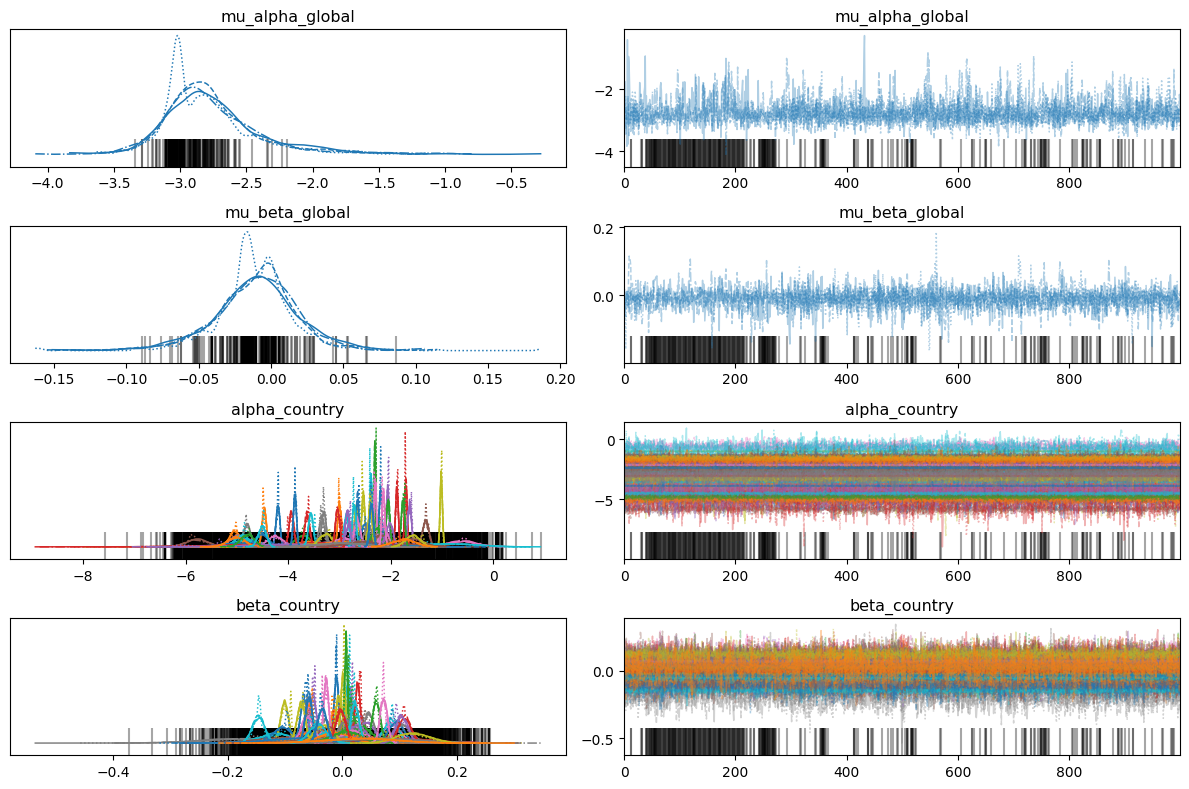

In [19]:
# Sampling and Convergence
az.plot_trace(trace, var_names=['mu_alpha_global', 'mu_beta_global', 'alpha_country', 'beta_country'])
plt.tight_layout()

In [20]:
# Get the summary DataFrame
summary_df = az.summary(trace, var_names=['alpha_country', 'beta_country'], hdi_prob=0.95)

# Create a mapping from index to country name
# We need the inverse of the country_idx dictionary
idx_to_country = {v: k for k, v in country_idx.items()}

# Extract the numerical index from the summary DataFrame index and map to country name
summary_df['Country'] = summary_df.index.map(lambda x: idx_to_country[int(x.split('[')[1].split(']')[0])])

# Reorder columns to put Country at the beginning
summary_df = summary_df[['Country'] + [col for col in summary_df.columns if col != 'Country']]

# Display the modified summary DataFrame
display(summary_df)

,Country,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_country[0],Argentina,-2.202,0.026,-2.253,-2.147,0.000,0.000,4642.0,2892.0,1.01
alpha_country[1],Australia,-5.049,0.095,-5.236,-4.862,0.001,0.002,5341.0,2906.0,1.01
alpha_country[2],Austria,-3.717,0.132,-3.984,-3.468,0.002,0.002,5569.0,3114.0,1.02
alpha_country[3],Belgium,-3.941,0.046,-4.025,-3.852,0.003,0.001,276.0,1115.0,1.02
alpha_country[4],Brazil,-2.059,0.026,-2.108,-2.006,0.000,0.001,3872.0,2930.0,1.00
...,...,...,...,...,...,...,...,...,...,...
beta_country[77],Uganda,0.070,0.063,-0.052,0.193,0.001,0.001,1931.0,2337.0,1.00
beta_country[78],Ukraine,0.121,0.029,0.073,0.177,0.002,0.001,215.0,293.0,1.02
beta_country[79],United Kingdom,-0.043,0.015,-0.072,-0.013,0.000,0.000,2588.0,2388.0,1.00
beta_country[80],Venezuela,-0.035,0.008,-0.050,-0.019,0.000,0.000,6236.0,2857.0,1.00


### 1. Trends and Patterns over time

In [21]:
beta_summary = az.summary(trace, var_names=['beta_country'], hdi_prob=0.95)
beta_summary.index = countries  # Map indices to country names
beta_summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Argentina,-0.010,0.004,-0.018,-0.001,0.000,0.000,5324.0,2057.0,1.01
Australia,-0.047,0.017,-0.081,-0.016,0.000,0.000,4075.0,1577.0,1.01
Austria,-0.020,0.025,-0.068,0.027,0.000,0.000,3663.0,2968.0,1.00
Belgium,-0.059,0.009,-0.076,-0.042,0.000,0.000,5248.0,2775.0,1.01
Brazil,0.014,0.006,0.003,0.025,0.000,0.000,1432.0,2203.0,1.00
...,...,...,...,...,...,...,...,...,...
Uganda,0.070,0.063,-0.052,0.193,0.001,0.001,1931.0,2337.0,1.00
Ukraine,0.121,0.029,0.073,0.177,0.002,0.001,215.0,293.0,1.02
United Kingdom,-0.043,0.015,-0.072,-0.013,0.000,0.000,2588.0,2388.0,1.00
Venezuela,-0.035,0.008,-0.050,-0.019,0.000,0.000,6236.0,2857.0,1.00


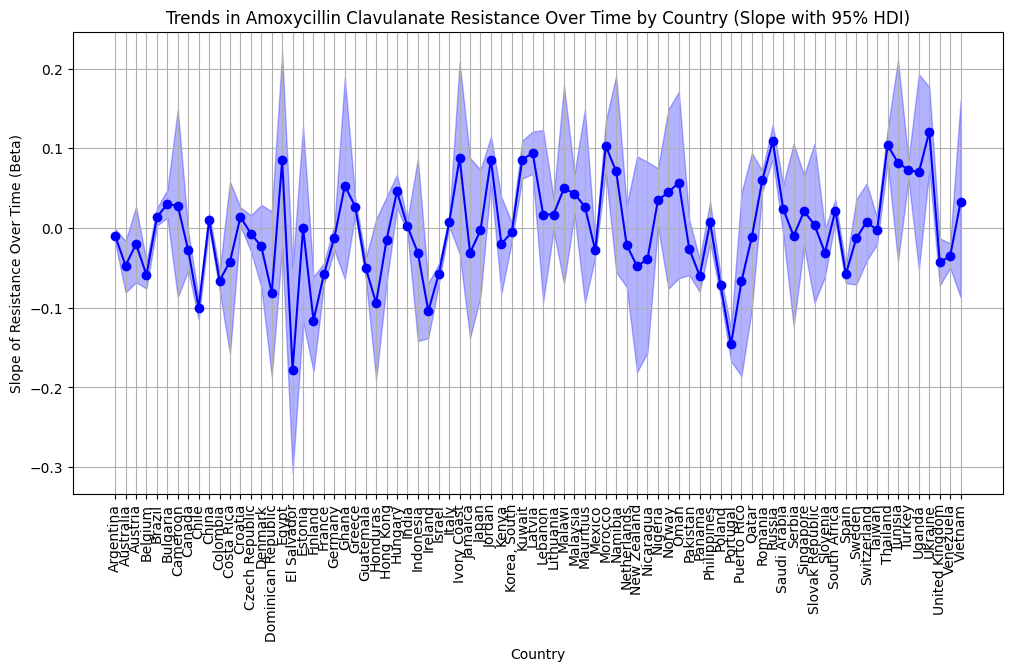

In [22]:
# Visualize trends
plt.figure(figsize=(12, 6))
plt.plot(beta_summary['mean'], marker='o', linestyle='-', color='b')
plt.fill_between(beta_summary.index,
                 beta_summary['hdi_2.5%'],
                 beta_summary['hdi_97.5%'],
                 color='b', alpha=0.3)

plt.xlabel('Country')
plt.ylabel('Slope of Resistance Over Time (Beta)')
plt.title('Trends in Amoxycillin Clavulanate Resistance Over Time by Country (Slope with 95% HDI)')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [23]:
import zipfile
with zipfile.ZipFile('/content/ne_110m_admin_0_countries.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')
    world = gpd.read_file('/content/ne_110m_admin_0_countries.shp')

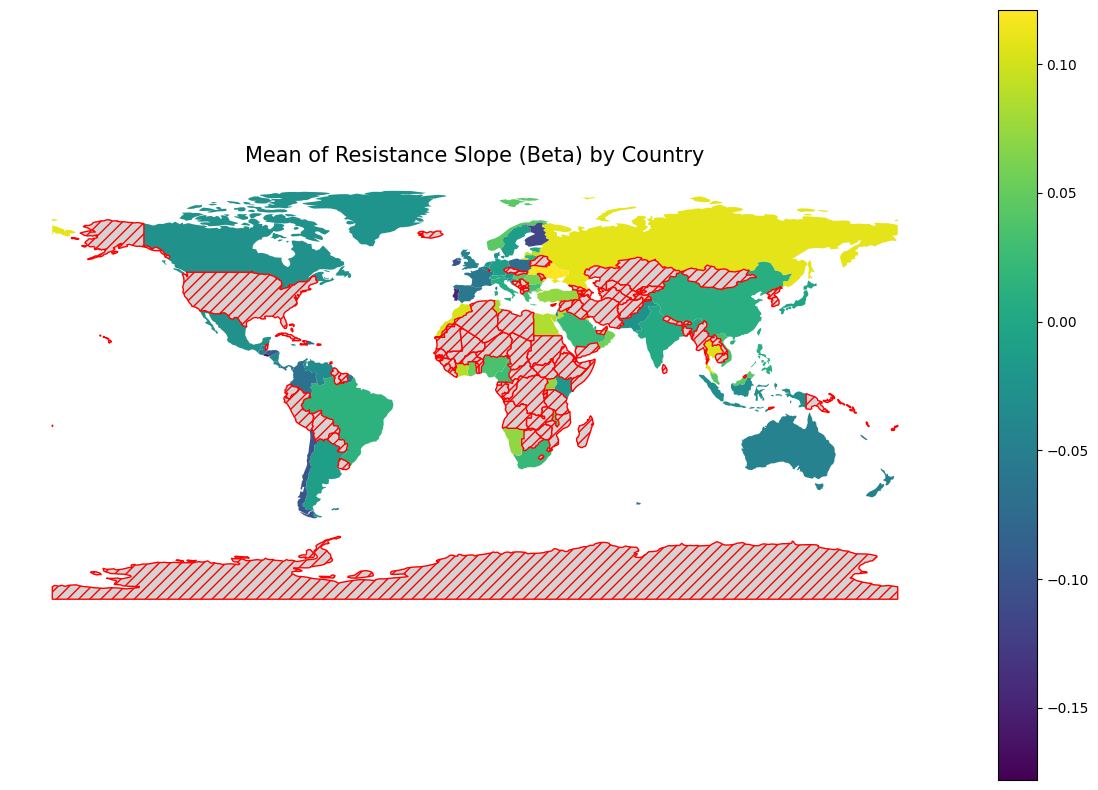

In [24]:
# Merge the world map data with the beta summary data
world_beta = world.merge(beta_summary, left_on='SOVEREIGNT', right_index=True, how='left')
# Define the column to be plotted (the mean of beta_country)
plot_column = 'mean'
# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_beta.plot(column=plot_column, ax=ax, legend=True,
                cmap='viridis',  # You can change the colormap
                missing_kwds={"color": "lightgrey",
                              "edgecolor": "red",
                              "hatch": "///",
                              "label": "Missing values"})
ax.set_title('Mean of Resistance Slope (Beta) by Country', fontsize=15)
ax.set_axis_off()
plt.show()

### 2. Comparing Regional and Country-Specific Differences

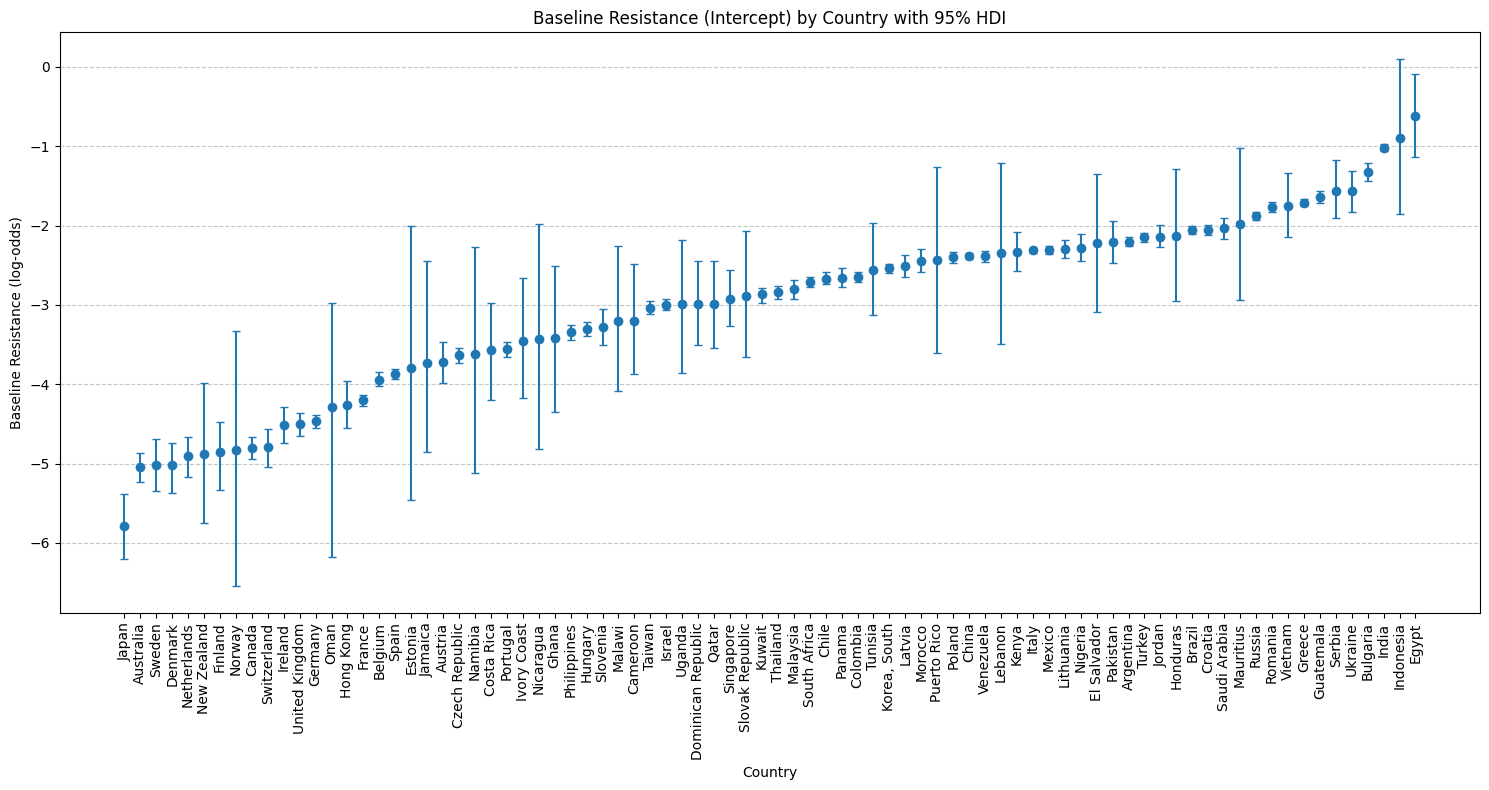

In [25]:
# Compare baseline resistance alpha and beta trends across countries
alpha_summary = az.summary(trace, var_names=['alpha_country'], hdi_prob=0.95)
alpha_summary.index = countries

# Calculate the lower and upper bounds for the error bars
alpha_summary['lower_hdi'] = alpha_summary['mean'] - alpha_summary['hdi_2.5%']
alpha_summary['upper_hdi'] = alpha_summary['hdi_97.5%'] - alpha_summary['mean']

# Sort the data by the mean value for better visualization
alpha_summary_sorted = alpha_summary.sort_values(by='mean')

# Create a bar plot with error bars
plt.figure(figsize=(15, 8)) # Adjust figure size as needed
plt.errorbar(alpha_summary_sorted.index, alpha_summary_sorted['mean'],
             yerr=[alpha_summary_sorted['lower_hdi'], alpha_summary_sorted['upper_hdi']],
             fmt='o', capsize=3, linestyle='None') # fmt='o' for markers, linestyle='None' for no line

plt.xlabel('Country')
plt.ylabel('Baseline Resistance (log-odds)')
plt.title('Baseline Resistance (Intercept) by Country with 95% HDI')
plt.xticks(rotation=90) # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

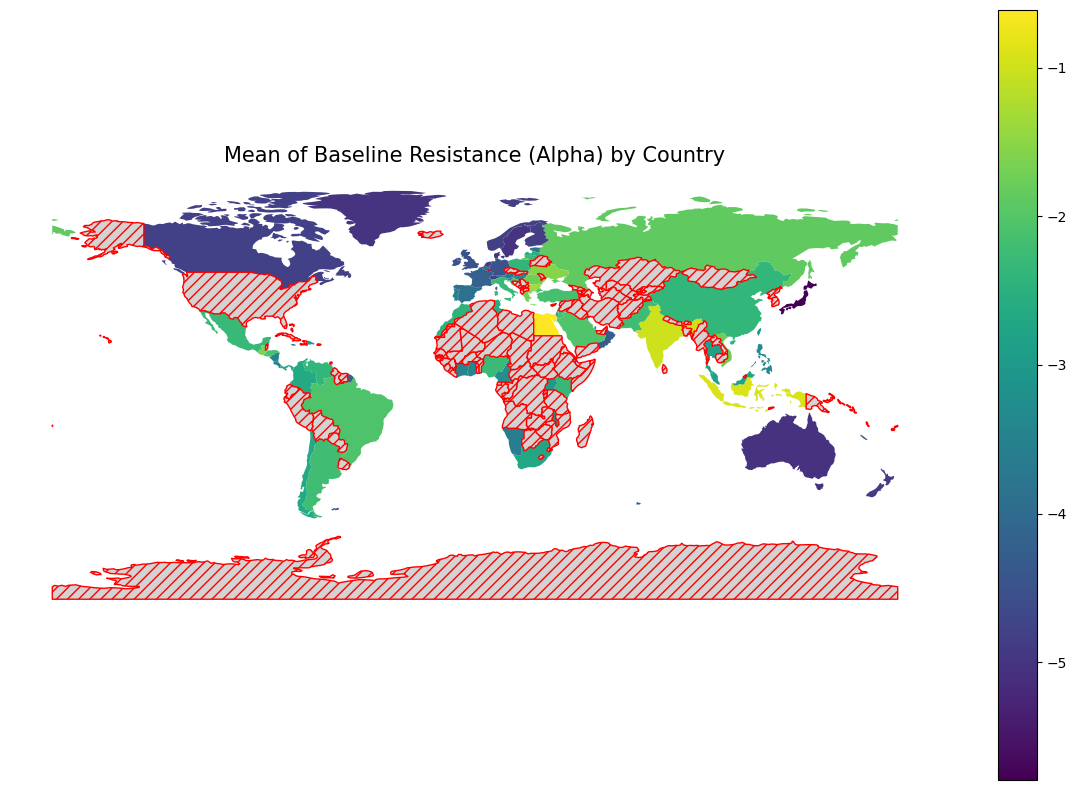

In [26]:
# Create a plot for alpha values on the map
world_alpha = world.merge(alpha_summary, left_on='SOVEREIGNT', right_index=True, how='left')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_alpha.plot(column='mean', ax=ax, legend=True,
                 cmap='viridis',  # Colormap for alpha
                 missing_kwds={"color": "lightgrey",
                               "edgecolor": "red",
                               "hatch": "///",
                               "label": "Missing values"})
ax.set_title('Mean of Baseline Resistance (Alpha) by Country', fontsize=15)
ax.set_axis_off()
plt.show()


**Interpretation**:
* Countries with significantly positive slopes are seeing rising resistance, while those with negative slopes are improving.

* Countries with higher `α` have higher baseline resistance. Compare HDIs to assess significant differences (non-overlapping HDIs suggest differences).


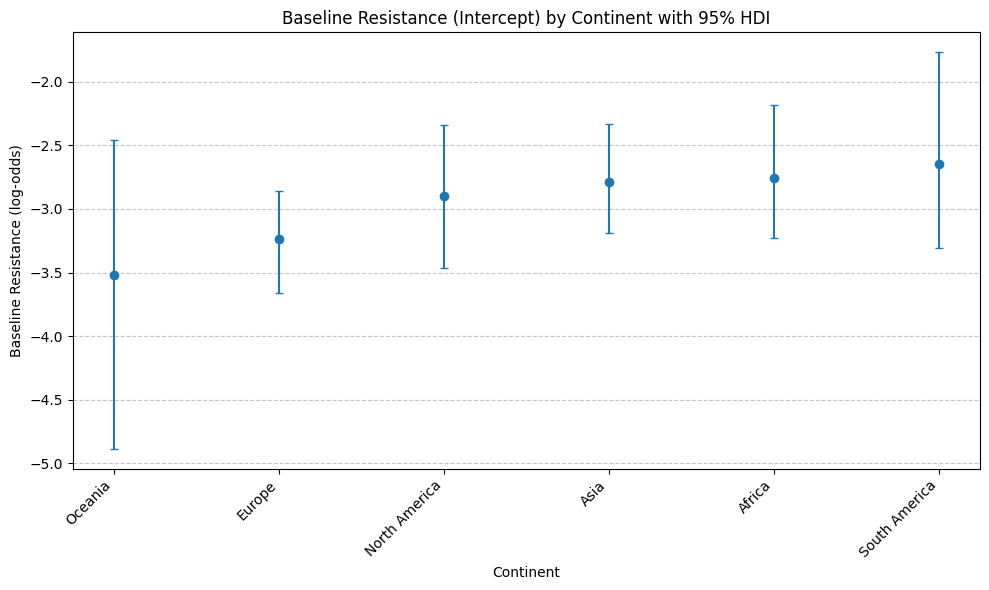

In [27]:
# Compare continents
continent_summary = az.summary(trace, var_names=['alpha_continent'], hdi_prob=0.95)

# Map the index to continent names
continent_summary.index = continents

# Calculate the lower and upper bounds for the error bars
continent_summary['lower_hdi'] = continent_summary['mean'] - continent_summary['hdi_2.5%']
continent_summary['upper_hdi'] = continent_summary['hdi_97.5%'] - continent_summary['mean']

# Sort the data by the mean value for better visualization
continent_summary_sorted = continent_summary.sort_values(by='mean')

# Create a bar plot with error bars
plt.figure(figsize=(10, 6)) # Adjust figure size as needed
plt.errorbar(continent_summary_sorted.index, continent_summary_sorted['mean'],
             yerr=[continent_summary_sorted['lower_hdi'], continent_summary_sorted['upper_hdi']],
             fmt='o', capsize=3, linestyle='None') # fmt='o' for markers, linestyle='None' for no line

plt.xlabel('Continent')
plt.ylabel('Baseline Resistance (log-odds)')
plt.title('Baseline Resistance (Intercept) by Continent with 95% HDI')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

**Interpretation**:
* Non-overlapping 95% HDIs for `βk` indicate significant differences in resistance trends across continents.
* Continent-level parameters (`αk`, `βk`) show regional patterns. For example, a continent with a high `αk` may indicate a regional challenge.

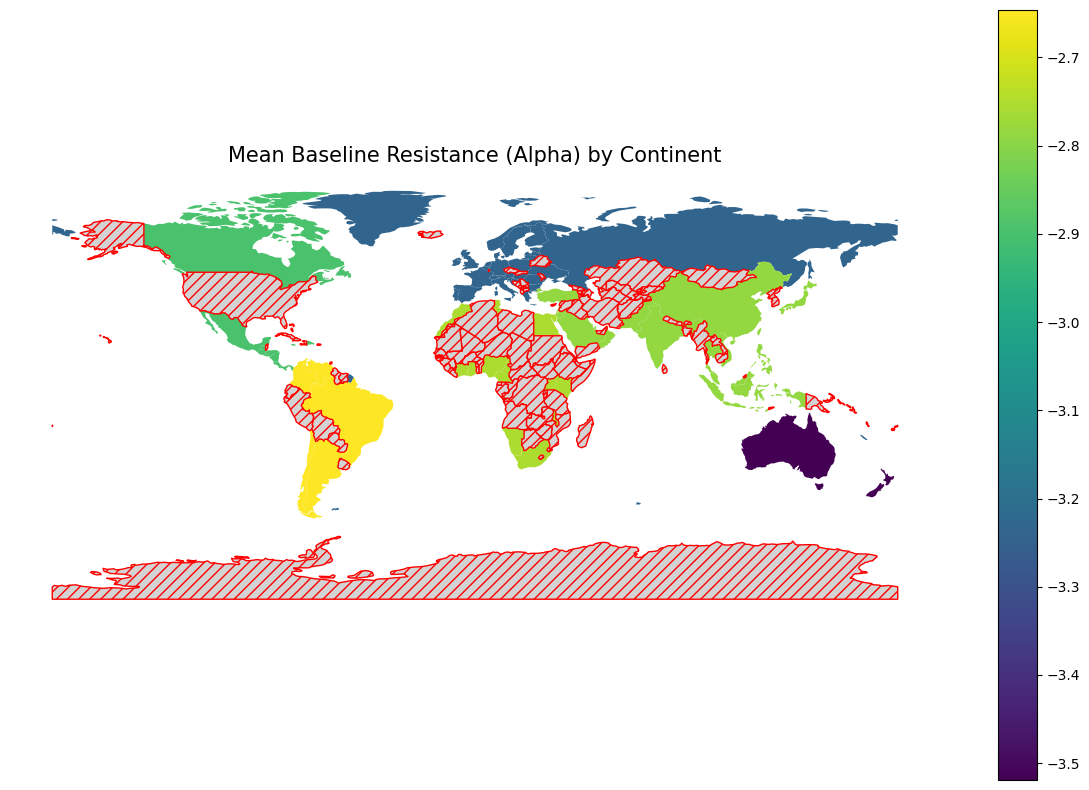

In [30]:
# Aggregate alpha values by continent from the trace
alpha_continent_trace = trace.posterior['alpha_continent'].mean(dim=('chain', 'draw'))

# Create a DataFrame for continent alpha values
continent_alpha_df = pd.DataFrame({
    'Continent': continents,
    'alpha_mean': alpha_continent_trace.values
})

# Add the 'Continent' column to the world GeoDataFrame based on the country_to_continent mapping
world['Continent'] = world['SOVEREIGNT'].map(country_to_continent)

# Calculate the mean alpha value for each continent by merging and aggregating
world_continent_alpha = world.merge(continent_alpha_df, on='Continent', how='left')

# Plot the mean alpha by continent on the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_continent_alpha.plot(column='alpha_mean', ax=ax, legend=True,
                           cmap='viridis',  # Colormap for alpha
                           missing_kwds={"color": "lightgrey",
                                         "edgecolor": "red",
                                         "hatch": "///",
                                         "label": "Missing values"})
ax.set_title('Mean Baseline Resistance (Alpha) by Continent', fontsize=15)
ax.set_axis_off()
plt.show()

###  3. Hotspots and Emerging Trends

In [31]:
# Identify hotspots by ranking countries by `αc` (baseline) and `βc` (trend)
hotspots_alpha = alpha_summary.sort_values(by='mean', ascending=False).head(5)
hotspots_beta = beta_summary.sort_values(by='mean', ascending=False).head(5)

In [32]:
# Merge with geospatial data
world_alpha = world.merge(alpha_summary, left_on='NAME', right_index=True, how='left')
world_beta = world.merge(beta_summary, left_on='NAME', right_index=True, how='left')

/tmp/ipython-input-33-1046350203.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(top5_alpha.geometry.centroid.x, top5_alpha.geometry.centroid.y, top5_alpha['NAME']):
/tmp/ipython-input-33-1046350203.py:29: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax1.legend(loc='lower left') # Add legend to ax1
/tmp/ipython-input-33-1046350203.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='lower left') # Add legend to ax1
/tmp/ipython-input-33-1046350203.py:50: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely inc

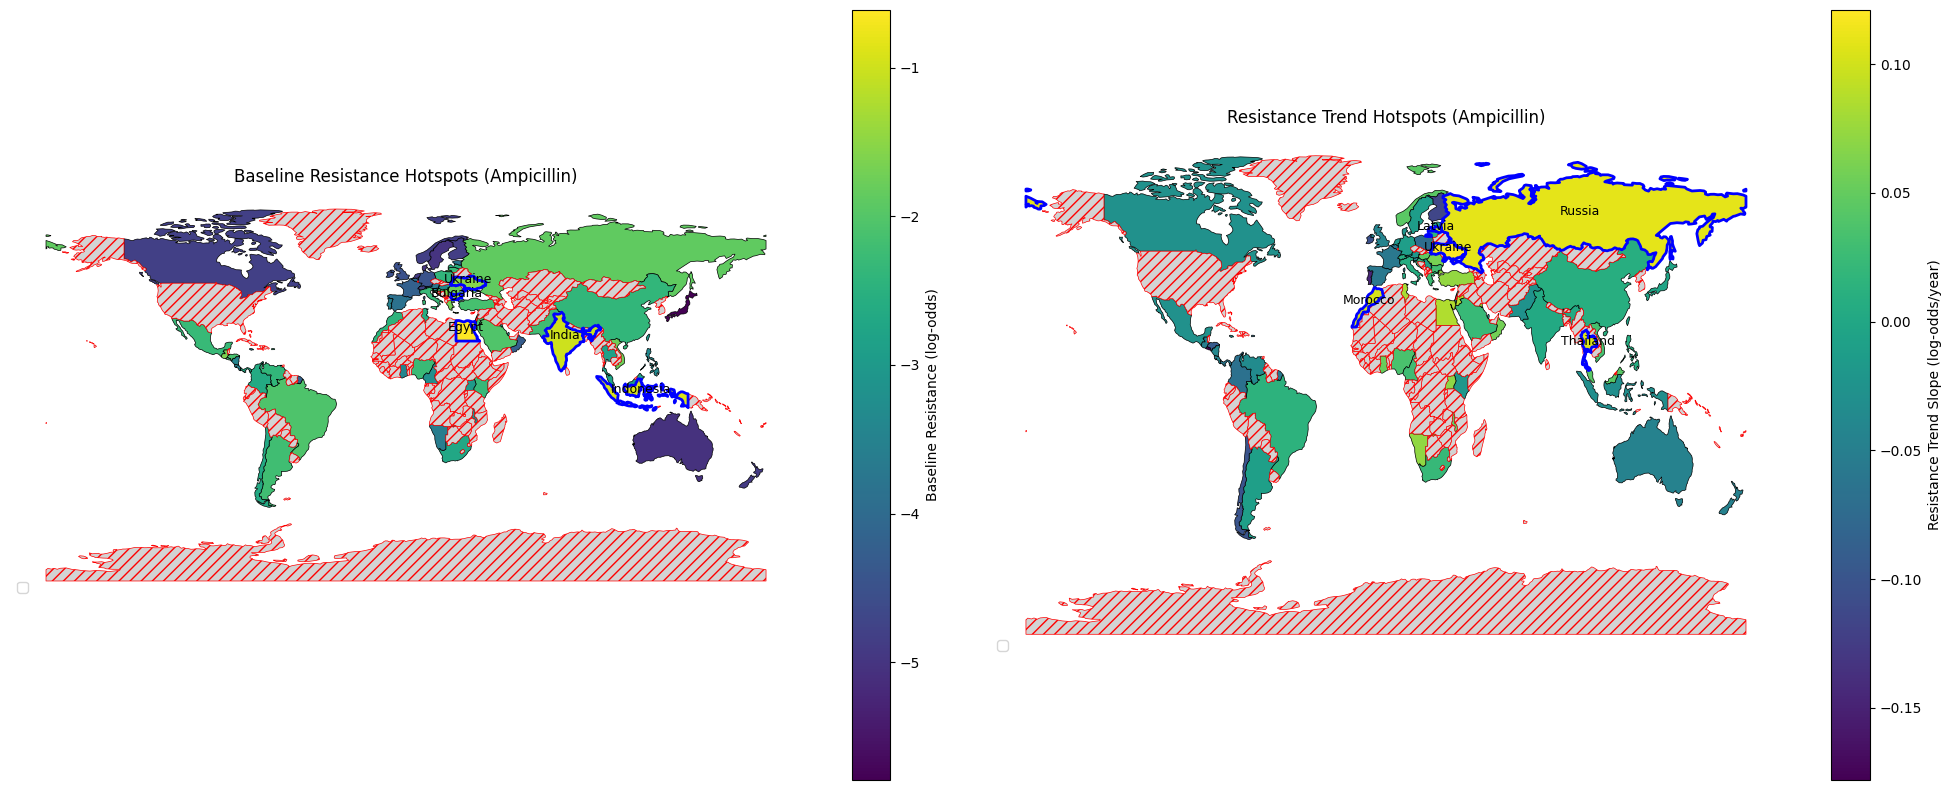

In [33]:
import matplotlib.patches as mpatches

# Create two subplots for baseline and trend
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), subplot_kw={'projection': None})

# Plot 1: Baseline Resistance (alpha_c)
world_alpha.plot(
    column='mean',  # Posterior mean of alpha_c
    cmap='viridis',
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': 'Baseline Resistance (log-odds)', 'orientation': 'vertical'},
    missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values"},
    ax=ax1
)

# Highlight top 5 hotspots
top5_alpha = world_alpha[world_alpha['NAME'].isin(hotspots_alpha.index)]
# Add label to the plot call for the legend
top5_alpha.plot(ax=ax1, color='none', edgecolor='blue', linewidth=2, label='Top 5 Hotspots (Baseline)')

# Add country names for top 5 alpha hotspots
for x, y, label in zip(top5_alpha.geometry.centroid.x, top5_alpha.geometry.centroid.y, top5_alpha['NAME']):
    ax1.text(x, y, label, fontsize=9, ha='center')

ax1.set_title('Baseline Resistance Hotspots (Ampicillin)')
ax1.set_axis_off()
ax1.legend(loc='lower left') # Add legend to ax1


# Plot 2: Resistance Trend Slope (beta_c)
world_beta.plot(
    column='mean',  # Posterior mean of beta_c
    cmap='viridis',
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': 'Resistance Trend Slope (log-odds/year)', 'orientation': 'vertical'},
    missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values"},
    ax=ax2
)

# Highlight top 5 hotspots
top5_beta = world_beta[world_beta['NAME'].isin(hotspots_beta.index)]
# Add label to the plot call for the legend
top5_beta.plot(ax=ax2, color='none', edgecolor='blue', linewidth=2, label='Top 5 Hotspots (Trend)')

# Add country names for top 5 beta hotspots
for x, y, label in zip(top5_beta.geometry.centroid.x, top5_beta.geometry.centroid.y, top5_beta['NAME']):
    ax2.text(x, y, label, fontsize=9, ha='center')

ax2.set_title('Resistance Trend Hotspots (Ampicillin)')
ax2.set_axis_off()
ax2.legend(loc='lower left')


plt.tight_layout()
plt.show()

**Interpretation**

* *Hotspots (High Baseline)*: Countries with high `αc` values (dark red, blue outline) have elevated resistance levels for Amikacin, indicating current public health challenges. These are critical areas for immediate intervention, such as enhanced antibiotic stewardship.
* *Hotspots (Rapid Increase)*: Countries with high `βc` values (dark red, blue outline) show rapid increases in resistance over time, signaling emerging threats. These areas may require proactive measures, like surveillance or policy changes, to prevent worsening resistance.
* *Geographical Patterns*: The maps reveal spatial clustering (e.g., if multiple high-resistance countries are in the same region)


#### 4. Detect MIC “creep” in the non-resistant population over time

In [45]:
# Prepare data
df = df.dropna(subset=['Country', 'Year', 'Amikacin', 'Amikacin_I', 'TEM', 'CTXM1', 'PER', 'KPC', 'OXA', 'NDM'])

# Sample 10% of data
df = df.sample(frac=0.1, random_state=42)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4625 entries, 74502 to 563765
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Isolate Id        4625 non-null   int64  
 1   Study             4625 non-null   object 
 2   Species           4625 non-null   object 
 3   Family            4625 non-null   object 
 4   Country           4625 non-null   object 
 5   State             0 non-null      float64
 6   Gender            4578 non-null   object 
 7   Age Group         4625 non-null   object 
 8   Speciality        4625 non-null   object 
 9   Source            4625 non-null   object 
 10  In / Out Patient  2326 non-null   object 
 11  Year              4625 non-null   int64  
 12  Phenotype         4625 non-null   object 
 13  AMPC              1344 non-null   object 
 14  SHV               4625 non-null   object 
 15  TEM               4625 non-null   object 
 16  CTXM1             4625 non-null   object 

In [47]:
# Create indices for Continent and Country for hierarchical modeling
continents = df['Continent'].unique()
continent_idx = {cont: i for i, cont in enumerate(continents)}

countries = df['Country'].unique()
country_idx = {country: i for i, country in enumerate(countries)}

df = df.copy()

df['continent_idx'] = df['Continent'].map(continent_idx)
df['country_idx'] = df['Country'].map(country_idx)

In [48]:
# Center the Year variable to improve model stability
df['year_centered'] = df['Year'] - df['Year'].mean()

In [49]:
df['Amikacin'].unique()

array(['32', '4', '1', '2', '16', '8', '>64', '<=0.5', '>32', '0.5', '64',
       '<=0.25'], dtype=object)

In [50]:
# Convert MIC values
def convert_mic_to_numeric(mic_value):
    if isinstance(mic_value, (int, float)):
        return float(mic_value)
    if isinstance(mic_value, str):
        mic_value = mic_value.replace('<=', '').replace('>=', '').replace('<', '').replace('>', '').strip()
        if not mic_value:
            return np.nan
        try:
            return float(mic_value)
        except ValueError:
            return np.nan
    return np.nan

df['Amikacin_numeric'] = df['Amikacin'].apply(convert_mic_to_numeric)

In [51]:
# Filter non-resistant isolates
non_resistant = df[df['Amikacin_I'].isin(['Susceptible', 'Intermediate'])].copy()

# Calculate log2 of the numeric Amikacin values
non_resistant.dropna(subset=['Amikacin_numeric'], inplace=True)
non_resistant['log2_mic'] = np.log2(non_resistant['Amikacin_numeric'])

In [52]:
# Assume lower detection limit (e.g., MIC <= 0.5 is censored)
lower_limit = np.log2(0.5)
non_resistant['censored'] = non_resistant['log2_mic'] <= lower_limit

In [53]:
n_continents = len(continents)
n_countries = len(countries)
# Create a mapping from all countries to their continents using the original dictionary
# Filter this mapping to include only countries present in the non_resistant dataframe
countries_in_non_resistant = non_resistant['Country'].unique()
continent_idx_for_non_resistant_countries = np.array([continent_idx[country_to_continent[c]] for c in countries if c in countries_in_non_resistant])

# Update countries and n_countries to reflect only those in the non_resistant dataframe
countries = countries_in_non_resistant
n_countries = len(countries)
country_idx = {country: i for i, country in enumerate(countries)}
non_resistant = non_resistant.copy() # Avoid SettingWithCopyWarning
non_resistant['country_idx'] = non_resistant['Country'].map(country_idx)

country_to_continent_for_model = continent_idx_for_non_resistant_countries

In [54]:
import pytensor.tensor as pt

with pm.Model() as mic_model:
    # Global hyperparameters
    mu_alpha_global = pm.Normal('mu_alpha_global', mu=0, sigma=1)
    sigma_alpha_global = pm.HalfNormal('sigma_alpha_global', sigma=1)
    mu_beta_global = pm.Normal('mu_beta_global', mu=0, sigma=1)
    sigma_beta_global = pm.HalfNormal('sigma_beta_global', sigma=1)

    # Continent-level parameters
    alpha_continent = pm.Normal('alpha_continent', mu=mu_alpha_global, sigma=sigma_alpha_global, shape=n_continents)
    beta_continent = pm.Normal('beta_continent', mu=mu_beta_global, sigma=sigma_beta_global, shape=n_continents)

    # Create intermediate tensors for continent-level means per country
    # Convert the NumPy array to a PyTensor tensor variable
    country_to_continent_tensor = pt.as_tensor_variable(country_to_continent_for_model, dtype='int64')

    alpha_continent_for_countries = alpha_continent[country_to_continent_tensor]
    beta_continent_for_countries = beta_continent[country_to_continent_tensor]

    # Country-level parameters
    sigma_alpha_country = pm.HalfNormal('sigma_alpha_country', sigma=1)
    sigma_beta_country = pm.HalfNormal('sigma_beta_country', sigma=1)
    # Use intermediate tensors as mu parameters
    alpha_country = pm.Normal('alpha_country', mu=alpha_continent_for_countries, sigma=sigma_alpha_country, shape=n_countries)
    beta_country = pm.Normal('beta_country', mu=beta_continent_for_countries, sigma=sigma_beta_country, shape=n_countries)

    # Linear predictor
    mu = alpha_country[non_resistant['country_idx'].values] + beta_country[non_resistant['country_idx'].values] * non_resistant['year_centered'].values
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Define likelihood using pm.Potential for left-censoring
    # For uncensored observations (log2_mic > lower_limit), add the log-pdf
    logp_observed = pm.logp(pm.Normal.dist(mu=mu, sigma=sigma), non_resistant['log2_mic'].values)

    # For censored observations (log2_mic <= lower_limit), add the log-cdf evaluated at the lower limit
    logp_censored = pm.logcdf(pm.Normal.dist(mu=mu, sigma=sigma), lower_limit)

    # Combine log-likelihoods based on the 'censored' flag
    # Use pt.where to select the appropriate log-likelihood for each observation
    total_logp = pt.where(non_resistant['censored'].values, logp_censored, logp_observed)

    # Add the total log-likelihood to the model using pm.Potential
    pm.Potential('observed_likelihood', total_logp)

    # Sample from posterior
    trace_mic = pm.sample(1000, tune=1000, chains=4, cores=4, return_inferencedata=True)

Output()

ERROR:pymc.stats.convergence:There were 618 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


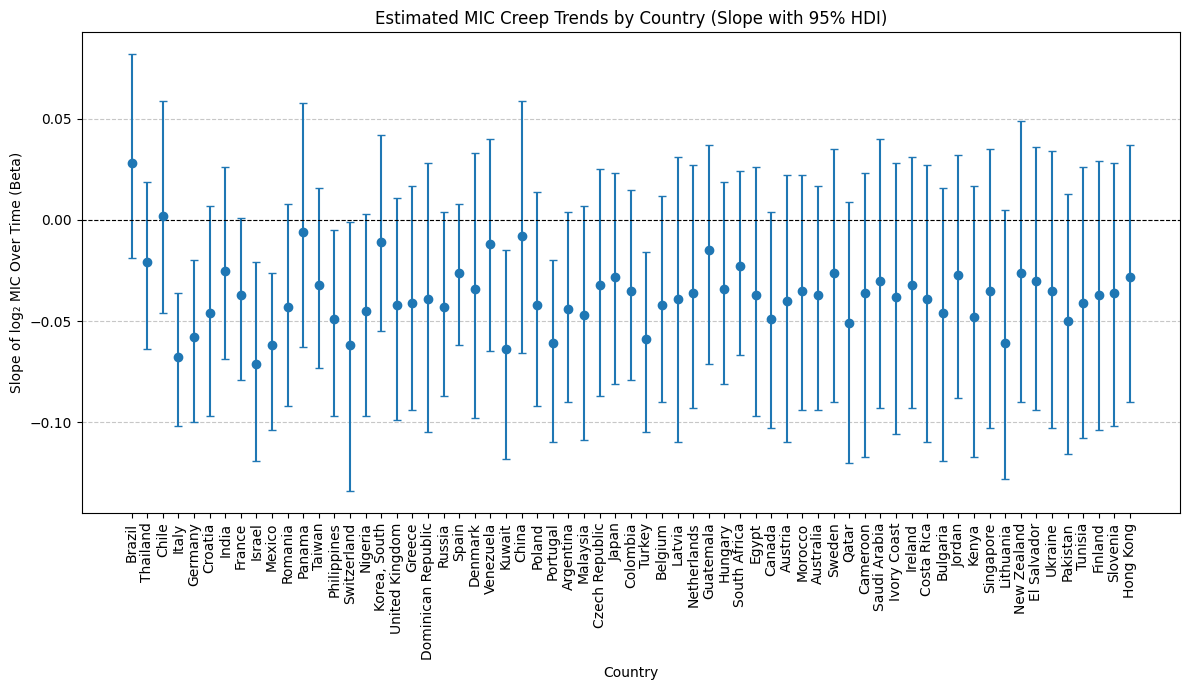

In [55]:
# Visualize MIC Creep (Slope of log₂ MIC) in Non-Resistant Population with countries on the x-axis
beta_summary = az.summary(trace_mic, var_names=['beta_country'], hdi_prob=0.95)
beta_summary.index = countries # Map indices to country names

plt.figure(figsize=(12, 7)) # Adjusted figure size for better readability
plt.errorbar(x=beta_summary.index, y=beta_summary['mean'],
             yerr=[beta_summary['mean'] - beta_summary['hdi_2.5%'], beta_summary['hdi_97.5%'] - beta_summary['mean']],
             fmt='o', capsize=3, linestyle='') # Use fmt='o' and linestyle='' for just points and error bars

plt.axhline(0, color='black', linestyle='--', linewidth=0.8) # Add a horizontal line at 0 for reference

plt.xlabel('Country')
plt.ylabel('Slope of log₂ MIC Over Time (Beta)')
plt.title('Estimated MIC Creep Trends by Country (Slope with 95% HDI)')
plt.xticks(rotation=90) # Rotate country names for readability
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a grid for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

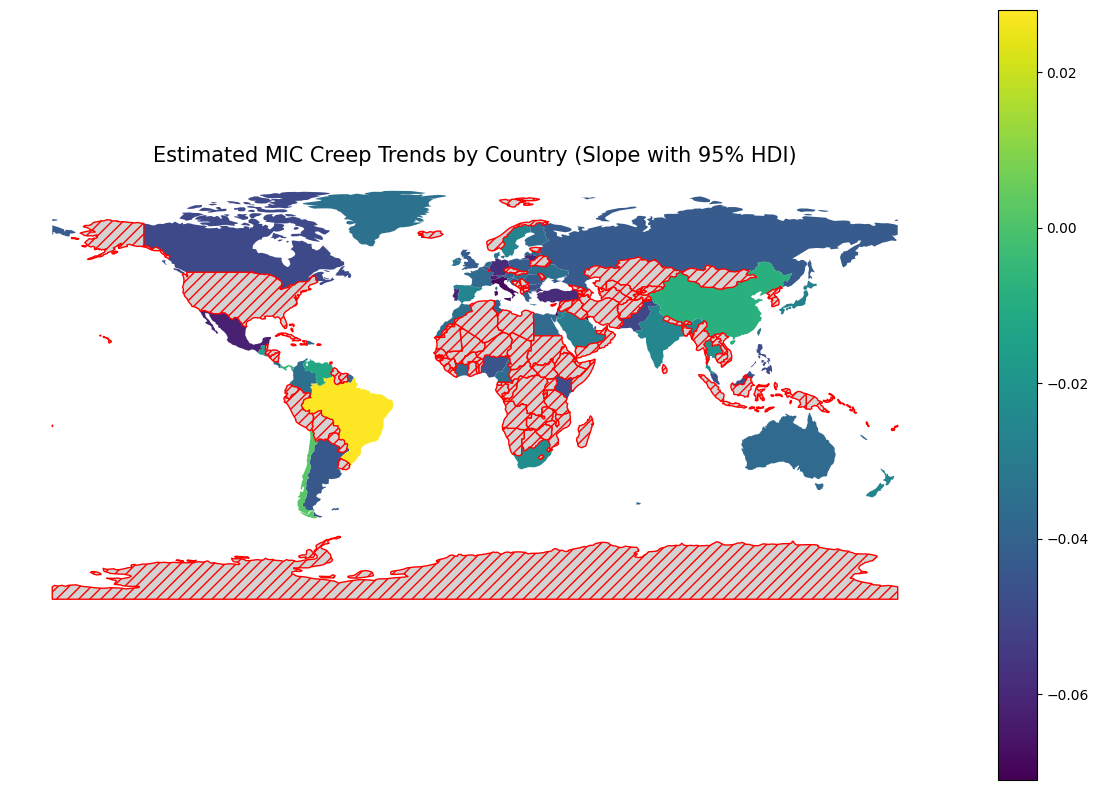

In [57]:
import matplotlib.pyplot as plt
# Merge the world map data with the beta summary data for MIC creep
world_beta_mic = world.merge(beta_summary, left_on='SOVEREIGNT', right_index=True, how='left')

# Define the column to be plotted (the mean of beta_country from the MIC model)
plot_column_mic = 'mean'

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_beta_mic.plot(column=plot_column_mic, ax=ax, legend=True,
                     cmap='viridis',  # Colormap for MIC creep slope
                     missing_kwds={"color": "lightgrey",
                                   "edgecolor": "red",
                                   "hatch": "///",
                                   "label": "Missing values"})

ax.set_title('Estimated MIC Creep Trends by Country (Slope with 95% HDI)', fontsize=15)
ax.set_axis_off()
plt.show()

### 5.  Estimate Genotype Association Effects Across Continents

#### Top 5 Resistance Genes for Cross-Continental Association Studies


* CTXM1: A globally dominant Extended Spectrum Beta-Lactamase (ESBL) gene—especially associated with resistance to cephalosporins like ceftriaxone, cefepime, and cefotaxime. Widely distributed across Africa, Asia, Europe, and the Americas.
* NDM: New Delhi Metallo-beta-lactamase—linked to resistance against carbapenems (imipenem, meropenem) and beta-lactams. Its emergence from India and rapid global spread makes it a vital marker for epidemiological tracking.
* OXA: Broad class (e.g., OXA-48, OXA-23) involved in resistance to carbapenems and penicillins. Frequently found in Europe, Africa, and the Middle East. Important for genes conferring multidrug resistance via mobile elements.
* KPC: Klebsiella pneumoniae carbapenemase—a leading cause of carbapenem resistance in North and South America, increasingly reported in European and African hospitals. Strongly associated with nosocomial outbreaks.
* TEM: Classical beta-lactamase gene—linked to ampicillin, penicillin, and even extended-spectrum resistance depending on mutations. TEM variants are ubiquitous and serve as foundational markers in resistance modeling.

In [58]:
# Define the list of genes to include in the model
genos = ['CTXM1', 'OXA', 'NDM', 'KPC', 'TEM']

# Prepare data
df['resistant'] = (df['Amikacin_I'] == 'Resistant').astype(int)

# Convert all specified gene columns to binary (1 if present, 0 otherwise)
for gene in genos:
    # Create a binary column for each gene. Assuming 'gene-Neg' indicates absence.
    df[f'{gene}_binary'] = (df[gene] != f'{gene}-Neg').astype(int)
    df[f'{gene}_binary'] = df[f'{gene}_binary'].fillna(0)


with pm.Model() as geno_model:
    # Continent-level baseline
    mu_alpha_global = pm.Normal('mu_alpha_global', mu=0, sigma=1)
    sigma_alpha_global = pm.HalfNormal('sigma_alpha_global', sigma=1)
    alpha_continent = pm.Normal('alpha_continent', mu=mu_alpha_global, sigma=sigma_alpha_global, shape=n_continents)

    # Country-level baseline
    sigma_alpha_country = pm.HalfNormal('sigma_alpha_country', sigma=1)
    # Use the correct variable: country_to_continent_for_model
    country_indices_for_prior = pt.as_tensor_variable(country_to_continent_for_model, dtype='int64')
    alpha_country = pm.Normal('alpha_country', mu=alpha_continent[country_indices_for_prior], sigma=sigma_alpha_country, shape=n_countries)

    # Global beta hyperparameters (for time trend - keeping for completeness if needed later)
    mu_beta_global = pm.Normal('mu_beta_global', mu=0, sigma=1)
    sigma_beta_global = pm.HalfNormal('sigma_beta_global', sigma=1)

    # Continent-level beta parameters (for time trend - keeping for completeness if needed later)
    beta_continent = pm.Normal('beta_continent', mu=mu_beta_global, sigma=sigma_beta_global, shape=n_continents)

    # Country-level beta parameters (for time trend - keeping for completeness if needed later)
    sigma_beta_country = pm.HalfNormal('sigma_beta_country', sigma=1)
    # Use the correct variable: country_to_continent_for_model
    beta_country_mu = pm.Deterministic('beta_country_mu', beta_continent[country_indices_for_prior])
    beta_country = pm.Normal('beta_country', mu=beta_country_mu, sigma=sigma_beta_country, shape=n_countries)


    # Continent-level gene effects (Gamma parameters for each gene)
    # Define a gamma parameter for each gene for each continent
    gamma_genes = {}
    for gene in genos:
        gamma_genes[gene] = pm.Normal(f'gamma_{gene}', mu=0, sigma=1, shape=n_continents)

    # Convert relevant pandas Series (now binary numeric) to PyTensor tensors for the linear predictor
    continent_indices_for_predictor = pt.as_tensor_variable(df['continent_idx'].values, dtype='int64')
    country_indices_for_predictor = pt.as_tensor_variable(df['country_idx'].values, dtype='int64')

    # Initialize the linear predictor with the baseline (alpha_country)
    linear_predictor = alpha_country[country_indices_for_predictor]

    # Add the gene effects to the linear predictor
    for gene in genos:
        gene_data = pt.as_tensor_variable(df[f'{gene}_binary'].values, dtype='float64')
        linear_predictor += gamma_genes[gene][continent_indices_for_predictor] * gene_data


    # Resistance rate (using sigmoid to link linear predictor to probability)
    p = pm.math.sigmoid(linear_predictor)

    # Likelihood (Binomial likelihood for binary resistance outcome)
    resistant_obs_data = pt.as_tensor_variable(df['resistant'].values)
    resistant_obs = pm.Binomial('resistant_obs', n=1, p=p, observed=resistant_obs_data)

    # Sample from posterior
    trace_geno = pm.sample(1000, tune=1000, chains=4, cores=4, return_inferencedata=True)

Output()

ERROR:pymc.stats.convergence:There were 1305 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


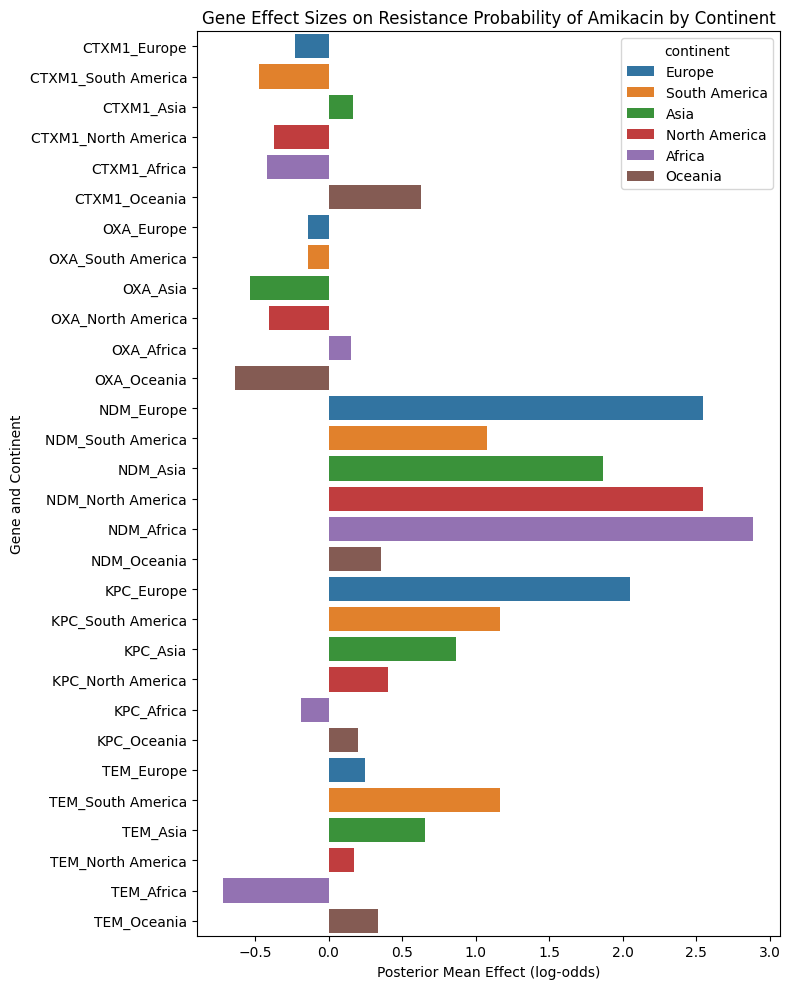

In [63]:
# Plot gene effect sizes by continent
gamma_var_names = [f'gamma_{gene}' for gene in genos]
gamma_summary = az.summary(trace_geno, var_names=gamma_var_names, hdi_prob=0.95)

# Adjust index for plotting - create a list of labels for y-axis
gamma_summary['gene'] = gamma_summary.index.map(lambda x: x.split('[')[0].replace('gamma_', ''))
gamma_summary['continent_idx'] = gamma_summary.index.map(lambda x: int(x.split('[')[1].replace(']', '')))

# Map continent index back to continent name
gamma_summary['continent'] = gamma_summary['continent_idx'].map({i: cont for i, cont in enumerate(continents)})

# Create combined label for plotting
gamma_summary['gene_continent'] = gamma_summary['gene'] + '_' + gamma_summary['continent']


plt.figure(figsize=(8, 10)) # Adjust figure size as needed to accommodate more genes
sns.barplot(x='mean', y='gene_continent', hue='continent', data=gamma_summary, dodge=False)

plt.title('Gene Effect Sizes on Resistance Probability of Amikacin by Continent')
plt.xlabel('Posterior Mean Effect (log-odds)')
plt.ylabel('Gene and Continent')
plt.tight_layout()
plt.show()

**Interpretation**: Larger γk values indicate stronger associations between genes and resistance. Non-overlapping HDIs suggest continent-specific differences.